In [5]:
import random
import math

import numpy as np
import pandas as pd
from pandas import DataFrame, Series


In [6]:
class EpsGreedyPolicy(object):
    def __init__(self, eps):
        self.eps = eps
        
    def select_action(self, n, step, q):
        if np.random.rand() < self.eps:
            return random.randint(0, n-1)
        max_q = max(q)
        max_action_indexes = [i for i, value in enumerate(q) if value == max_q]
        return random.choice(max_action_indexes)
    
class GreedyPolicy(EpsGreedyPolicy):
    def __init__(self):
        super(GreedyPolicy, self).__init__(eps=0)
        
class NonStationaryBanditFactory(object):
    class NonStationaryBandit(object):
        def __init__(self, initial_mu, initial_variance, generate_params_fun):
            self.mu = initial_mu
            self.variance = initial_variance
            self.generate_params_fun = generate_params_fun
            
        def play(self):
            reward = np.random.normal(self.mu, math.sqrt(self.variance))
            return reward
        
        def generate_new_params(self):
            self.mu = self.generate_params_fun(self.mu)
    
    def __init__(self, initial_bandit_mu, bandit_value_variance, bandit_random_walk_step_size):
        self.bandit_value_variance = bandit_value_variance
        self.initial_bandit_mu = initial_bandit_mu
        self.bandits = []
        self.bandit_random_walk_step_size = bandit_random_walk_step_size
        
    def generate(self):
        bandit = self.NonStationaryBandit(
            initial_mu=self.initial_bandit_mu, 
            initial_variance=self.bandit_value_variance,
            generate_params_fun=lambda old_mu: old_mu + random.choice([-1, 1])*self.bandit_random_walk_step_size)
        self.bandits.append(bandit)
        return bandit
    
    def is_optimal_action(self, action_idx):
        opt_mu = max(bandit.mu for bandit in self.bandits)
        opt_bandits = [idx for idx, bandit in enumerate(self.bandits) if bandit.mu == opt_mu]
        return action_idx in opt_bandits
        
        

In [7]:
class NonStationaryBanditTask(object):
    """
    Represents n-armed bandit task
    """
    def __init__(self, num_bandits, bandit_factory):
        self.num_bandits = num_bandits
        self.bandit_factory = bandit_factory
        self.bandits = [bandit_factory.generate() for _ in xrange(self.num_bandits)]
        
    def _play_once(self, step, policy, update_value_method):
        """
        Plays n-armed bandit task once using a given policy
        and updates value action for the selected action with the observed reward
        according to given update_value_method
        """
        action_idx = policy.select_action(
            n=self.num_bandits, 
            step=step,
            q=self.q)
        reward = self.bandits[action_idx].play()
        self.history_rewards.append(reward)
        optimal_action_selected = self.bandit_factory.is_optimal_action(action_idx)
        self.history_optimal_action_selected.append(optimal_action_selected)
        self.q[action_idx] = update_value_method(
            old_value=self.q[action_idx],
            reward=reward,
            step=step)
    
    def _init_simulation(self, initial_action_value):
        """
        Initializes all variables that are required for the simulation:
        - initial action values
        - number of times action was selected
        - summary reward of actions
        - history_rewards is a history of all obtained rewards
        """
        
        self.q = [initial_action_value for _ in xrange(self.num_bandits)]
        self.history_rewards = []
        self.history_optimal_action_selected = []
        
    def run_simulation(self, num_plays, policy, initial_action_value, update_value_method):
        """
        Runs the n-armed bandit tasks for num_plays number of plays with eps-greedy policy,
        initial_action_value denoting the initial action value of all actions (bandits)
        and with given update_value_method 
        
        policy: a function that takes 3 parameters: number of bandits, play number, current action value estimates
        and returs a single integer denoting the index of selected action, 
        i.e. integer in range [0, num_bandits-1]
        
        update_value_method: a function that takes an old value estimate, a current reward and a step number
        and returns a new value estimate
        
        returns a tuple:
        - list of all history rewards obtained
        - list of bool variables indicating whether an optimal action was selected during whole history
        """
        
        self._init_simulation(initial_action_value=initial_action_value)
        
        for step in xrange(1, num_plays+1):
            self._play_once(
                step=step, 
                policy=policy,
                update_value_method=update_value_method)
            
            # updating bandits
            for bandit in self.bandits:
                bandit.generate_new_params()
            
        return self.history_rewards, self.history_optimal_action_selected
            

In [21]:
%%time

POLICIES = {
    "eps-greedy=0.1": EpsGreedyPolicy(eps=0.1),
}
UPDATE_VALUE_METHODS = {
    "sample-average": lambda old_value, reward, step: old_value + (1.0/float(step)) * (reward-old_value),
    "constant step-size alpha=0.1": lambda old_value, reward, step: old_value + 0.1*(reward-old_value),
}

NUM_SIMULATIONS = 2000
NUM_PLAYS = 2000
NUM_BANDITS = 10
INITIAL_ACTION_VALUE = 0
BANDIT_RANDOM_WALK_STEP_SIZE = 0.1
results = {}

for policy_name, policy in POLICIES.items():
    for update_value_method_name, update_value_method in UPDATE_VALUE_METHODS.items():
        all_history_rewards = []
        all_optimal_action_selected = []
        for simuliation_idx in xrange(NUM_SIMULATIONS):
            bandit_factory = NonStationaryBanditFactory(
                initial_bandit_mu=0.0,
                bandit_value_variance=1.0,
                bandit_random_walk_step_size=BANDIT_RANDOM_WALK_STEP_SIZE)
            task = NonStationaryBanditTask(
                num_bandits=NUM_BANDITS,
                bandit_factory=bandit_factory)
            history_rewards, history_optimal_action_selected = task.run_simulation(
                num_plays=NUM_PLAYS, 
                policy=policy, 
                initial_action_value=INITIAL_ACTION_VALUE,
                update_value_method=update_value_method)
            all_history_rewards.append(history_rewards)
            all_optimal_action_selected.append(history_optimal_action_selected)
        variant_name = "%s; %s" % (policy_name, update_value_method_name)
        results[variant_name] = (
            DataFrame(all_history_rewards),
            DataFrame(all_optimal_action_selected),
        )


CPU times: user 3min 39s, sys: 1.27 s, total: 3min 41s
Wall time: 3min 42s


Text(0.5,0,'Plays')

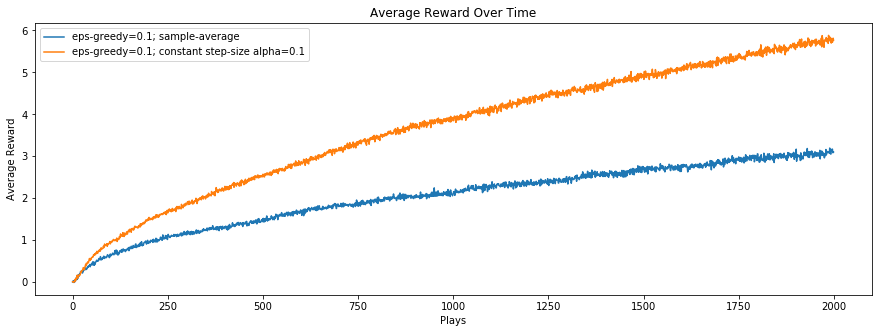

In [22]:
for variant_name, (history_rewards, _) in results.items():
    ax = history_rewards.mean(axis=0).plot(legend=True, figsize=(15,5))
legend = ax.legend()
for i in xrange(len(results)):
    legend.get_texts()[i].set_text(results.keys()[i])
ax.set_title('Average Reward Over Time')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Plays")
    


Text(0.5,0,'Plays')

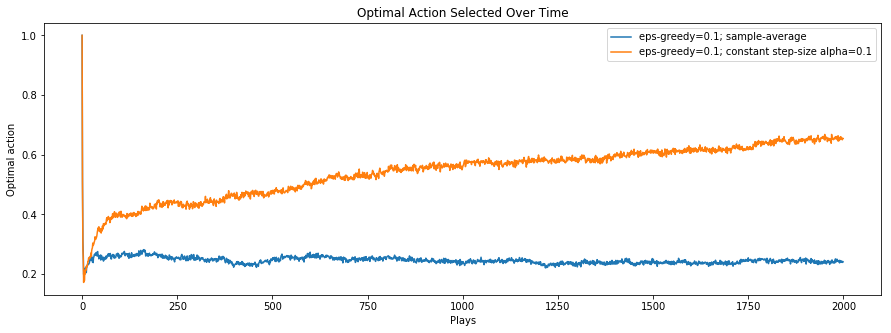

In [23]:
for variant_name, (_, history_optimal_action_selected) in results.items():
    ax = history_optimal_action_selected.mean(axis=0).plot(legend=True, figsize=(15,5))
legend = ax.legend()
for i in xrange(len(results)):
    legend.get_texts()[i].set_text(results.keys()[i])
ax.set_title('Optimal Action Selected Over Time')
ax.set_ylabel('Optimal action')
ax.set_xlabel("Plays")